In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations, chain, product

import mipcl_py.mipshell.mipshell as mip

%load_ext line_profiler

%matplotlib inline

In [48]:
NS = NodesData_wSlice(np.array([1., 0., 2., 3., 0.]),W)
NS[S]

array([ 1.,  2.])

In [43]:
S = NodesSlice('d',np.array([1,3]))
S.index

array([1, 3])

In [71]:
%lprun -f test_slice test_slice(True,100000)

In [70]:
def test_slice(S,n):
    if S:
        N = NodesData_wSlice(np.array([1., 0., 2., 3., 0.]),W)
    else:
        N = NodesData(np.array([1., 0., 2., 3., 0.]),W)
        
    for _ in range(n):
        s = NodesSlice('d',np.array([1,3]))
        a = N[s]

In [39]:
class NodesSlice:
    def __init__(self, t, index):
        self.t = t
        self.index = index

class NodesData_wSlice(NodesData):
    
    def __getitem__(self, key):
        if isinstance(key, NodesSlice):
            if key.t == 'd':
                return self.data[key.index-1]
            else:
                return self.data[key.index+self.matchingGraph.nb_demand_classes-1]
        else:
            i, j = key
            return self.data[[i-1, j+self.matchingGraph.nb_demand_classes-1]]
    

In [2]:
class MatchingGraph:
    
    def __init__(self, edges, nb_demand_classes, nb_supply_classes):
        # Edges must be a list of tuples ('i','j') if demand class i can be matched with supply class j
        self.edges = edges
        self.nb_demand_classes = nb_demand_classes
        self.nb_supply_classes = nb_supply_classes
        # We compute the set and all subsets of demand classes
        self.demand_class_set = np.arange(1,self.nb_demand_classes+1)
        self.demand_class_subsets = [tuple(c) for c in chain.from_iterable(combinations(self.demand_class_set, r) for r in self.demand_class_set)]
        # We create a dictionary which maps each subset of demand classes to the subset of supply classes to witch its linked
        self.build_demandToSupply()
        # We compute the set and all subsets of supply classes
        self.supply_class_set = np.arange(1,nb_supply_classes+1)
        self.supply_class_subsets = [tuple(c) for c in chain.from_iterable(combinations(self.supply_class_set, r) for r in np.arange(1,nb_supply_classes+1))]
        # We create a dictionary which maps each subset of supply classes to the subset of demand classes to witch its linked
        self.build_supplyToDemand()
        
    @property
    def n(self):
        return self.nb_demand_classes + self.nb_supply_classes
    
    @property
    def nodes(self):
        # We create a list of all nodes with first the demand classes and then the supply classes, both in increasing order
        return np.array(['d'+str(i) for i in self.demand_class_set] + ['s'+str(j) for j in self.supply_class_set])
        
    def build_demandToSupply(self):
        # We create a dictionary which maps each subset of demand classes to the subset of supply classes to witch its linked
        self.demandToSupply = {}
        for subset in self.demand_class_subsets:
            supply_subset = set()
            for edge in self.edges:
                if edge[0] in subset:
                    supply_subset.add(edge[1])
            self.demandToSupply[tuple(subset)] = list(supply_subset)
            
    def build_supplyToDemand(self):
        # We create a dictionary which maps each subset of supply classes to the subset of demand classes to witch its linked
        self.supplyToDemand = {}
        for subset in self.supply_class_subsets:
            demand_subset = set()
            for edge in self.edges:
                if edge[1] in subset:
                    demand_subset.add(edge[0])
            self.supplyToDemand[tuple(subset)] = list(demand_subset)
            
    def isEdge(self, e):
        return e in self.edges
    
    def Dcomplement(self, D):
        return tuple(i for i in self.demand_class_set if i not in D)
    
    def Scomplement(self, S):
        return tuple(j for j in self.supply_class_set if j not in S)
    
    def edgeIndex(self, e):
        if self.isEdge(e):
            return self.edges.index(e)
        else:
            raise ValueError('This value does not correspond to an egde of the matching graph')
        
    def degree(self):
        # We count the degree of each node
        d = NodesData(np.zeros(self.n),self)
        for edge in self.edges:
            d[edge] += 1
        return d
    
    def maximal_matchings(self):
        # We compute all the maximal matchings of the matching graph. This function only makes sense if it called on the MatchingGraph returned by available_matchings_subgraph()
        list_maximal_matchings = []
        deg = self.degree().data
        # We look at all nodes of degree superior than 2 (there can not be more than 2)
        if (deg<2).all():
            # If the degree of each node is less than two then all the edges of the matching graph form the only maximal matching
            list_maximal_matchings.append(self.edges)
        elif np.sum(deg>=2)==1:
            # We get the index of the node
            node_index = int(np.where(deg>=2)[0])
            # We test if it is a demand class or a supply class
            if node_index < self.nb_demand_classes:
                # We transform the node index to the demand class
                node = node_index + 1
                # We get all the supply classes that can be matched with arrival demand class
                S_i = self.demandToSupply[(node,)]
                # We test if there is still an edge we can matched after having matched the arrival demand class
                remaining_edge = [el for el in set(self.edges).difference((node, supply_class) for supply_class in S_i)]
                if remaining_edge:
                    for supply_class in S_i:
                        list_maximal_matchings.append([(node, supply_class),remaining_edge])
                else:
                    for supply_class in S_i:
                        list_maximal_matchings.append([(node, supply_class)])
            else:
                # We transform the node index to the supply class
                node = node_index - self.nb_demand_classes + 1
                # We get all the demand classes that can be matched with arrival supply class
                D_j = self.supplyToDemand[(node,)]
                # We test if there is still an edge we can matched after having matched the arrival supply class
                remaining_edge = [el for el in set(self.edges).difference((demand_class, node) for demand_class in D_j)]
                if remaining_edge:
                    for demand_class in D_j:
                        list_maximal_matchings.append([(demand_class, node),remaining_edge])
                else:
                    for demand_class in D_j:
                        list_maximal_matchings.append([(demand_class, node)])
        else:       
            # We get the demand class and the supply class of the arrivals by selecting the only two nodes that have a degree greater than 2
            arrivals_classes_index = np.where(deg>=2)[0]
            arrivals_classes = (arrivals_classes_index[0]+1, arrivals_classes_index[1]-self.nb_demand_classes+1)
            # We get all the supply classes that can be matched with arrival demand class
            S_i = self.demandToSupply[(arrivals_classes[0],)]
            # We get all the demand classes that can be matched with arrival supply class
            D_j = self.supplyToDemand[(arrivals_classes[1],)]
            
            if arrivals_classes[1] in S_i:
                # If both arrivals can be matched together, we add their matching as a maximal matching and remove them from S_i and D_j
                list_maximal_matchings.append([arrivals_classes])
                S_i.remove(arrivals_classes[1])
                D_j.remove(arrivals_classes[0])
                
            # We get all remaining maximal matchings by combining any possible matching of arrival demand class with any possible matching of arrival supply class
            for classes in product(S_i,D_j):
                list_maximal_matchings.append([(arrivals_classes[0],classes[0]),(classes[1],arrivals_classes[1])])
            
        return list_maximal_matchings
    
# We define a class NodesData which is a data structure for our system. 
# It stores a value for each classes of demand and supply items.
# It is used for example to store the length of the queues, the holding costs or the arrival rates
class NodesData:
        
    def __init__(self, A, matchingGraph):
        # The values must be stored, in a Numpy Array, organized as such: first the demand items, then the supply items and both sorted by classes in increasing order
        # This means that index i represent demand class i+1 and index nb_demand_classes+j represent supply class j+1
        self.data = A
        self.matchingGraph = matchingGraph
      
    @classmethod
    def fromDict(cls, D, matchingGraph):
        A = np.zeros(matchingGraph.n)
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
            elif node[0]=='d':
                A[int(node[1])-1] = D[node]
            else:
                A[matchingGraph.nb_demand_classes+int(node[1])-1] = D[node]
        return cls(A,matchingGraph)
        
    @classmethod
    def zeros(cls, matchingGraph):
        # We create an empty state
        return cls(np.zeros(matchingGraph.n), matchingGraph)
    
    @classmethod
    def items(cls, demand_items, supply_items, matchingGraph):
        # We create a state by giving two separate array for demand and supply items
        return cls(np.hstack((demand_items,supply_items)), matchingGraph)
    
    def demand(self, classes):
        return self.data[classes-1]
    
    def supply(self, classes):
        return self.data[classes-1+self.matchingGraph.nb_demand_classes]
    
    def __getitem__(self, index):
        i, j = index
        return self.data[[i-1, self.matchingGraph.nb_demand_classes+j-1]]
    
    def __setitem__(self, index, value):
        i, j = index
        self.data[[i-1, self.matchingGraph.nb_demand_classes+j-1]] = value
    
    def __add__(self, other):
        return self.__class__(self.data + other.data, self.matchingGraph)
    
    def __iadd__(self, other):
        self.data += other.data
        return self   
    
    def copy(self):
        return self.__class__(self.data.copy(),self.matchingGraph)

# We define a class State which is a NodesData with the constraint that demand and supply items must be positives and their sum equal
# It is used for example to store the length of the queues, arrival items or matchings
class State(NodesData):
    
    def __init__(self, values, matchingGraph):
        # We use the NodesData initialization
        super(State,self).__init__(values, matchingGraph)     
        # We test that the number of demand items and the number of supply items are positives
        if (self.data < 0).any():
            raise ValueError("The number of demand items and the number of supply items must be positives.")
        # We test that the sum of demand items is equal to the sum of supply items
        if self.demand(self.matchingGraph.demand_class_set).sum() != self.supply(self.matchingGraph.supply_class_set).sum():
            raise ValueError("The sum of demand items must be equal to the sum of supply items.")
        
    def matchings_available(self):
        # We construct a list of all the edges which can be matched given the State
        list_edges = []
        for edge in self.matchingGraph.edges:
            if (self[edge]>=1).all():
                list_edges.append(edge)
        return list_edges
    
    def matchings_available_subgraph(self):
        # We construct a subgraph composed of all the edges which can be matched given the State
        return MatchingGraph(self.matchings_available(), self.matchingGraph.nb_demand_classes, self.matchingGraph.nb_supply_classes)
    
    def __iadd__(self, other):
        if isinstance(other, State):
            self.data += other.data
            return self
        else:
            raise TypeError("A State can only be added with another State")
    
    def __sub__(self, other):
        if isinstance(other, Matching):
            return State(self.data - other.data, self.matchingGraph) 
        else:
            raise TypeError("Items from a State can only be substracted with a Matching")
        
    def __isub__(self, other):
        if isinstance(other, Matching):
            self.data -= other.data
            return self 
        else:
            raise TypeError("Items from a State can only be substracted with a Matching")
    
# We define a class Virtual State that acts as a State excepts that we allow negative values. 
# This type of states are used in Stolyar policy
class Virtual_State(NodesData):
    
    def __init__(self, values, matchingGraph):
        # We use the NodesData initialization
        super(Virtual_State,self).__init__(values, matchingGraph)
        # We test that the sum of demand items is equal to the sum of supply items
        if self.demand(self.matchingGraph.demand_class_set).sum() != self.supply(self.matchingGraph.supply_class_set).sum():
            raise ValueError("The sum of demand items must be equal to the sum of supply items.")
        
    def __iadd__(self, other):
        if isinstance(other, State) or isinstance(other, Virtual_State):
            self.data += other.data
            return self
        else:
            raise TypeError("A Virtual_State can only be added with another Virtual_State or another State")
    
    def __sub__(self, other):
        if isinstance(other, Virtual_Matching):
            return Virtual_State(self.data - other.data, self.matchingGraph) 
        else:
            raise TypeError("Items from a State can only be substracted with a Virtual Matching")
        
    def __isub__(self, other):
        if isinstance(other, Virtual_Matching):
            self.data -= other.data
            return self 
        else:
            raise TypeError("Items from a State can only be substracted with a Virtual Matching")
            
    
# We create a Matching class which is a State with more restrictions.
# A matching can only add pairs of demand and supply items if they are associated to an edge in the matching graph.
# A matching has a reference to a State and can't have more items than the referenced State in any nodes.
class Matching(State):
    
    def __init__(self, x, values):
        super(Matching,self).__init__(values, x.matchingGraph)
        # We store a reference to the State on which we will perform matchings
        self.x = x
        # We test if the number of matchings is higher than the number of items in the State
        if (self.data > x.data).any():
            raise ValueError("The number of matched items can't be superior than the number of items in the State at any nodes")
        if not self.feasible():
            raise ValueError("This matching is not feasible")
    
    def feasible(self):
        feasible_matching = True
        for subset in self.matchingGraph.demand_class_subsets:
            if self.demand(np.array(subset)).sum() > self.supply(np.array(self.matchingGraph.demandToSupply[subset])).sum():
                feasible_matching = False
        for subset in self.matchingGraph.supply_class_subsets:
            if self.supply(np.array(subset)).sum() > self.demand(np.array(self.matchingGraph.supplyToDemand[subset])).sum():
                feasible_matching = False
        return feasible_matching
    
    @classmethod
    def fromDict(cls, x, D):
        A = np.zeros(x.matchingGraph.n)
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in x.matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
            elif node[0]=='d':
                A[int(node[1])-1] = D[node]
            else:
                A[x.matchingGraph.nb_demand_classes+int(node[1])-1] = D[node]
        return cls(x, A)
        
    @classmethod
    def zeros(cls, x):
        # We create an empty state
        return cls(x, np.zeros(x.matchingGraph.n))
    
    @classmethod
    def items(cls, x, demand_items, supply_items):
        # We create a state by giving two separate array for demand and supply items
        return cls(x, np.hstack((demand_items,supply_items)))
    
    def __setitem__(self, index, value):
        # We test if the demand class i can be matched with the supply class j
        if self.matchingGraph.isEdge(index):
            # We test if the number of matchings has exceed the number of items in the State
            if (value>self.x[index]).any():
                raise ValueError("The number of matched items can't be superior than the number of items in the State at any nodes")
            else:
                super(Matching,self).__setitem__(index,value)
        else:
            raise ValueError("The pair do not correspond to an edge in the matching graph")
            
    def copy(self):
        return Matching(self.x,self.data.copy())
            
# We define a Virtual Matching class which is the same as the Matching class excepts that we allow matchings to be made even if there is not enough items.
# This type of matching is used in Stolyar policy
class Virtual_Matching(State):
    
    def __init__(self, x, values):
        super(Virtual_Matching,self).__init__(values, x.matchingGraph)
        # We store a reference to the State on which we will perform matchings
        self.x = x
        # We test if the matching is feasible, i.e if it is a linear combination of edges from the matching graph
        if not self.feasible():
            raise ValueError("This matching is not feasible")
    
    def feasible(self):
        feasible_matching = True
        for subset in self.matchingGraph.demand_class_subsets:
            if self.demand(np.array(subset)).sum() > self.supply(np.array(self.matchingGraph.demandToSupply[subset])).sum():
                feasible_matching = False
        for subset in self.matchingGraph.supply_class_subsets:
            if self.supply(np.array(subset)).sum() > self.demand(np.array(self.matchingGraph.supplyToDemand[subset])).sum():
                feasible_matching = False
        return feasible_matching
    
    @classmethod
    def fromDict(cls, x, D):
        A = np.zeros(x.matchingGraph.n)
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in x.matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
            elif node[0]=='d':
                A[int(node[1])-1] = D[node]
            else:
                A[x.matchingGraph.nb_demand_classes+int(node[1])-1] = D[node]
        return cls(x, A)
        
    @classmethod
    def zeros(cls, x):
        # We create an empty state
        return cls(x, np.zeros(x.matchingGraph.n))
    
    @classmethod
    def items(cls, x, demand_items, supply_items):
        # We create a state by giving two separate array for demand and supply items
        return cls(x, np.hstack((demand_items,supply_items)))
    
    def __setitem__(self, index, value):
        # We test if the demand class i can be matched with the supply class j
        if self.matchingGraph.isEdge(index):
            super(Virtual_Matching,self).__setitem__(index,value)
        else:
            raise ValueError("The pair do not correspond to an edge in the matching graph")
            
    def copy(self):
        return Virtual_Matching(self.x,self.data.copy())
        
          
class Model:
    
    def __init__(self, matchingGraph, arrival_dist, costs, x_0):
        self.matchingGraph = matchingGraph
        # We initialize the class probabilities
        self.arrival_dist = arrival_dist
        # We stores the holding costs
        self.costs = costs
        # We initialize the state of the system (the length of each queue)
        self.x_0 = x_0
        
    def sample_arrivals(self):
        a = State.zeros(self.matchingGraph)
        # We sample the class of the demand item
        d = np.random.choice(self.matchingGraph.demand_class_set,p=self.arrival_dist.demand(self.matchingGraph.demand_class_set))
        # We sample the class of the supply item
        s = np.random.choice(self.matchingGraph.supply_class_set,p=self.arrival_dist.supply(self.matchingGraph.supply_class_set))
        a[d,s]+=1
        return a
    
    def iterate(self,states_list,policies):
        # We sample new arrivals
        arrivals = self.sample_arrivals()
        for p, policy in enumerate(policies):
            # We apply the matchings
            states_list[p] -= policy.match(states_list[p]) 
            # We add the arrivals
            states_list[p] += arrivals
        #return states_list
        
    def run(self, nb_iter, policies, traj=False, plot=False):
        nb_policies = len(policies)
        # states_list stores the state of the system under each policy given by the list policies
        states_list = []
        # We intialize each state to the initial state of the model x_0 and reset each policy
        for policy in policies:
            states_list.append(self.x_0.copy())
            policy.reset_policy(self.x_0)
            
        if plot:
            traj = True
        if traj:
            # We keep the trajectory of the system under each policy
            state_size = self.matchingGraph.n
            trajectories = np.zeros((nb_policies,state_size,nb_iter+1))
            trajectories[:,:,0] = self.x_0.data
            for i in np.arange(nb_iter):
                self.iterate(states_list,policies) 
                trajectories[:,:,i+1] = [state.data for state in states_list]
            
            if plot:
                # We plot the trajectories
                fig, axes = plt.subplots(nb_policies,1,figsize=(15,nb_policies*5),squeeze=0)
                for p, policy in enumerate(policies):
                    for e in np.arange(state_size):
                        lab = "d_"+str(e+1) if e<self.matchingGraph.nb_demand_classes else "s_"+str(e-self.matchingGraph.nb_demand_classes+1)
                        axes[p,0].plot(trajectories[p,e,:],label=lab)
                    axes[p,0].legend(loc='best')
                    axes[p,0].set_title(str(policy))
            return trajectories
        else:
            for _ in np.arange(nb_iter):
                self.iterate(states_list,policies)
            return states_list
        
    def average_cost(self, nb_iter, policies, plot=False):
        x_traj = self.run(nb_iter, policies, traj=True)
        costs_traj = [np.cumsum(np.dot(self.costs.data.reshape(1,-1),x_traj[i,:,:]))/np.arange(1.,nb_iter+2) for i in np.arange(len(policies))]
        if plot:
            # We plot the costs trajectory
            plt.figure(figsize=(15,5))
            for p, policy in enumerate(policies):
                plt.plot(costs_traj[p],label=str(policy))
            plt.legend(loc='best')
        return costs_traj
        
        

In [24]:
# We define a class for policies
class Policy:

    def match(self,x):
        raise NotImplementedError
        
    def reset_policy(self, x_0):
        pass
    
    def __str__(self):
        pass
    
# We define various policies by creating child class from Policy and implementing the function match()

# We define a random policy which choose a random possible (depending on the State) matching. 
# The policy has a parameter that gives the maximum number of times we repeat the last operation.
class Random_policy(Policy):
    
    def __init__(self,nb_matchings_max=np.inf):
        assert nb_matchings_max==np.inf or (type(nb_matchings_max)==int and nb_matchings_max>=1)
        self.nb_matchings_max = nb_matchings_max
    
    def match(self,x):
        nb_matchings = 0
        u = Matching.zeros(x)
        possible_matchings = x.matchings_available()
        while nb_matchings < self.nb_matchings_max and possible_matchings:
            edge = possible_matchings[np.random.randint(len(possible_matchings))]
            u[edge] += 1.
            nb_matchings += 1
            new_state = x - u
            possible_matchings = new_state.matchings_available()
        return u
    
    def __str__(self):
        return 'Random policy m={}'.format(self.nb_matchings_max)
    
class Threshold_policy(Policy):
    
    def __init__(self,thresholds):
        # We store the thresholds as [s_1, s_2]
        self.thresholds = thresholds
        
    def match(self,x):
        u = Matching.zeros(x)
        # We match all l4
        u[3,2] += x[3,2].min()
        # We match all l1
        u[1,1] += x[1,1].min()
        # We update the state with the matchings in l4 and l1 because they have priority and they influence the ones in l2 and l3
        new_state = x - u
        # We match all l2 above the s_1 threshold
        l2_matchings = np.maximum(new_state[2,1].min() - self.thresholds[0], 0.)
        u[2,1] += l2_matchings
        # We match all l3 above the s_2 threshold
        l3_matchings = np.maximum(new_state[2,2].min() - self.thresholds[1], 0.)
        u[2,2] += l3_matchings
        return u
    
    def __str__(self):
        return 'Threshold policy t={}'.format(self.thresholds)
    
class MaxWeight_policy(Policy):
    
    def __init__(self, costs):
        self.costs = costs
    
    def match(self,x):
        # We suppose that x is a stable state (i.e, before the arrivals, no more matching could have been done)
        u = Matching.zeros(x)
        # We will use a list of edges candidates that could achieve the max weight
        candidate_list = x.matchings_available_subgraph().maximal_matchings()
        candidates_costs = np.zeros(len(candidate_list))
        for i, candidate in enumerate(candidate_list):
            # For each candidate we compute the costs induced by its matchings
            for edge in candidate:
                candidates_costs[i] += np.sum(self.costs[edge])
        # We create a Matching out of the most expensive candidate
        for edge in candidate_list[np.argmax(candidates_costs)]:
            u[edge] += 1.
        return u
    
    def __str__(self):
        return 'MaxWeight policy'
    
class Stolyar_policy(Policy):
    
    def __init__(self, x_0, rewards, beta, costs=None):
        self.previous_x = x_0.copy()
        self.previous_match = Matching.zeros(x_0)
        self.virtual_x = Virtual_State(x_0.data.copy(), x_0.matchingGraph)
        self.rewards = rewards
        self.beta = beta
        self.incomplete_matchings = []
        # We can include holding costs in Stolyar algorithm by giving the costs as parameter and changing the virtual system update
        if costs is not None:
            self.costs = costs
            self.update_vs = self.update_virtual_system_wCosts
        else:
            self.update_vs = self.update_virtual_system
    
    def match(self,x):
        # update the virtual system: add previous arrivals, apply algo 1 and add the matching to the incomplete queue
        self.update_vs(x)
        # We scan the queue in FCFS order until we find a feasible match given x
        # We return the feasible if one was found or we return 0.
        for match in self.incomplete_matchings:
            if (match.data <= x.data).all():
                u = Matching(x, match.data)
                self.incomplete_matchings.remove(match)
                self.previous_match = u
                return u
        u = Matching.zeros(x)
        self.previous_match = u
        return u
    
    def update_virtual_system(self,x):
        # We add the previous arrivals to the virtual state
        arrivals = State(x.data - self.previous_x.data + self.previous_match.data, x.matchingGraph)
        self.virtual_x += arrivals
        self.previous_x = x.copy()
        # We use Stolyar algorithm to get the matching based on the virtual system
        virtual_match = Virtual_Matching.zeros(x)
        matchings_values = np.zeros(len(self.rewards))
        for i, edge in enumerate(x.matchingGraph.edges):
            matchings_values[i] = self.rewards[i] + self.beta*np.sum(self.virtual_x[edge])
        virtual_match[x.matchingGraph.edges[np.argmax(matchings_values)]]+=1.
        # We perform the matching in the virtual system
        self.virtual_x -= virtual_match
        # We add the matching to the list of incomplete matchings
        self.incomplete_matchings.append(virtual_match)
        
    def update_virtual_system_wCosts(self,x):
        # We add the previous arrivals to the virtual state
        arrivals = State(x.data - self.previous_x.data + self.previous_match.data, x.matchingGraph)
        self.virtual_x += arrivals
        self.previous_x = x.copy()
        # We use Stolyar algorithm to get the matching based on the virtual system
        virtual_match = Virtual_Matching.zeros(x)
        matchings_values = np.zeros(len(self.rewards))
        for i, edge in enumerate(x.matchingGraph.edges):
            matchings_values[i] = self.rewards[i] + self.beta*np.dot(self.costs[edge].reshape(1,-1),self.virtual_x[edge].reshape(-1,1))
        virtual_match[x.matchingGraph.edges[np.argmax(matchings_values)]]+=1.
        # We perform the matching in the virtual system
        self.virtual_x -= virtual_match
        # We add the matching to the list of incomplete matchings
        self.incomplete_matchings.append(virtual_match)
        
    def reset_policy(self,x_0):
        # We reset the previous state, matching and virtual state
        self.previous_x = x_0.copy()
        self.previous_match = Matching.zeros(x_0)
        self.virtual_x = Virtual_State(x_0.data.copy(), x_0.matchingGraph)
        # We empty the list of incomplete matchings
        self.incomplete_matchings = []
        
    def __str__(self):
        if hasattr(self, 'costs'):
            return 'Stolyar policy with costs r={}, b={}'.format(self.rewards,self.beta)
        else:
            return 'Stolyar policy r={}, b={}'.format(self.rewards,self.beta)
        
class hMWT_policy(Policy):
    
    def __init__(self, matchingGraph, Workload_index, alpha, costs, beta, kappa, theta, delta_plus, NUmax):
        # The Workload_index must be a list with two element. 
        # The first one is 'd' if we are looking at demand classes or 's' for supply classes
        # The second one is a tuple with the classes
        assert Workload_index[0] == 'd' or Workload_index[0] == 's'
        self.Workload_index = Workload_index
        self.NUmax = NUmax # The maximal number of matchings that can be done at once
        self.alpha = alpha # The mean arrival rate
        self.costs = costs # The linear costs
        self.beta = beta # The perturbation parameter to turn x (or w) in xtil (or wtil)
        self.kappa = kappa
        self.theta = theta
        self.delta_plus = delta_plus
        
        if self.Workload_index[0] == 'd':
            D = self.Workload_index[1]
            S_D = tuple(matchingGraph.demandToSupply[D])
            self.Idle_index = [matchingGraph.edgeIndex((d,s)) for s in S_D for d in matchingGraph.supplyToDemand[(s,)] if d not in D]
            self.XiD = np.array([1. if idx in D else 0. for idx in matchingGraph.demand_class_set]+[-1. if idx in S_D else 0. for idx in matchingGraph.supply_class_set])
            
            # We compute the optimal threshold tau_star
            Delta_plus = self.alpha.demand(np.array(D)).sum()
            Delta_minus = self.alpha.supply(np.array(S_D)).sum()
            delta = Delta_minus - Delta_plus
            self.barC_plus = self.costs.demand(np.array(D)).min() + self.costs.supply(np.array(matchingGraph.Scomplement(S_D))).min()
            self.barC_minus = self.costs.demand(np.array(matchingGraph.Dcomplement(D))).min() + self.costs.supply(np.array(S_D)).min()
            #sigmaSq_delta = (delta + 1.)**2 * Delta_plus*(1.-Delta_minus) + (delta - 1.)**2 * (1.-Delta_plus)*Delta_minus # Ana code version
            sigmaSq_delta = Delta_plus*(1.-Delta_minus) + (1.-Delta_plus)*Delta_minus - delta**2 # My version
            self.tau_star = 0.5*(sigmaSq_delta/delta)*np.log(1.+(self.barC_plus/self.barC_minus))
            
            # We compute coefficients needed for hat_h
            hat_etaSS = self.tau_star*self.barC_minus
            self.Aplus = self.barC_plus/(2*delta)
            self.Bplus = (sigmaSq_delta*self.Aplus-hat_etaSS)/delta
            self.THETA = 2*delta/sigmaSq_delta
            self.Aminus = -self.barC_minus/(self.THETA*sigmaSq_delta)
            self.Bminus = 2*self.Aminus/self.THETA - hat_etaSS/delta
            self.Dminus = (self.Bplus-self.Bminus)/self.THETA
            
            self.match = self.match_D
        else:
            S = self.Workload_index[1]
            D_S = tuple(matchingGraph.supplyToDemand[S])
            self.Idle_index = [matchingGraph.edgeIndex((d,s)) for d in D_S for s in matchingGraph.demandToSupply[(d,)] if s not in S]
            self.XiS = np.array([-1. if idx in D_S else 0. for idx in matchingGraph.demand_class_set]+[1. if idx in S else 0. for idx in matchingGraph.supply_class_set])
        
            # We compute the optimal threshold tau_star
            Delta_plus = self.alpha.supply(np.array(S)).sum()
            Delta_minus = self.alpha.demand(np.array(D_S)).sum()
            delta = Delta_minus - Delta_plus
            self.barC_plus = self.costs.supply(np.array(S)).min() + self.costs.demand(np.array(matchingGraph.Dcomplement(D_S))).min()
            self.barC_minus = self.costs.supply(np.array(matchingGraph.Scomplement(S))).min() + self.costs.demand(np.array(D_S)).min()
            #sigmaSq_delta = (delta + 1.)**2 * Delta_plus*(1.-Delta_minus) + (delta - 1.)**2 * (1.-Delta_plus)*Delta_minus # Ana code version
            sigmaSq_delta = Delta_plus*(1.-Delta_minus) + (1.-Delta_plus)*Delta_minus - delta**2 # My version
            self.tau_star = 0.5*(sigmaSq_delta/delta)*np.log(1.+(self.barC_plus/self.barC_minus))
            
            # We compute coefficients need for hat_h
            hat_etaSS = self.tau_star*self.barC_minus
            self.Aplus = self.barC_plus/(2*delta)
            self.Bplus = (sigmaSq_delta*self.Aplus-hat_etaSS)/delta
            self.THETA = 2*delta/sigmaSq_delta
            self.Aminus = -self.barC_minus/(self.THETA*sigmaSq_delta)
            self.Bminus = 2*self.Aminus/self.THETA - hat_etaSS/delta
            self.Dminus = (self.Bplus-self.Bminus)/self.THETA
        
            self.match = self.match_S
    
    def match_D(self, x):
        # We compute the workload w
        w = np.inner(x.data, self.XiD)
        # We computed the pertubated states and workload
        xtil = x.data + self.beta*(np.exp(-x.data/self.beta)-1.)
        wtil = np.sign(w)*(np.abs(w) + self.beta*(np.exp(-np.abs(w)/self.beta)-1.))
        
        # The function h is the sum of two function: \hat{h}(w) et h_c(x)
        # We compute the gradient of h_c(x)
        grad_ctil = np.multiply(self.costs.data,(1. - np.exp(-x.data/self.beta)))
        if w>=0:
            grad_barCtil = self.barC_plus*(1.-np.exp(-w/self.beta))*self.XiD
        else:
            grad_barCtil = -self.barC_minus*(1.-np.exp(w/self.beta))*self.XiD
        grad_h_c = 2.*self.kappa*(np.inner(self.costs.data, xtil) - np.maximum(self.barC_plus*wtil, -self.barC_minus*wtil) )*(grad_ctil - grad_barCtil)
        # We compute the derivative of \hat{h}(w)
        if w>=0:
            hat_hprime = 2*self.Aplus*w+self.Bplus
        elif w<0 and w>=-self.tau_star:
            #hat_hprime = 2*self.Aminus + self.Bminus + self.Dminus*self.THETA*np.exp(self.THETA*w) # Ana code version
            hat_hprime = 2*self.Aminus*w + self.Bminus + self.Dminus*self.THETA*np.exp(self.THETA*w) # My version
        else:
            ws = self.tau_star + w
            hat_hprime = (self.barC_minus/self.delta_plus)*(ws+(1/self.theta)*(1-np.exp(self.theta*ws)))
        # Finally, we compute the gradient of h(x)
        grad_h = hat_hprime*self.XiD + grad_h_c
        
        prob = hMWT("hMWT")
        prob.model(x, grad_h, w, self.tau_star, self.Idle_index, self.NUmax)
        prob.optimize(False)
        if prob.is_solution == True:
            u_star = Matching.zeros(x)
            for i in np.arange(len(x.matchingGraph.edges)):
                u_star[x.matchingGraph.edges[i]] = prob.u[i].val
            return u_star
        else:
            raise ValueError('The MIP optimizer has not found a solution')
        #prob.printSolution()
        
    def match_S(self, x):
        # We compute the workload w
        w = np.inner(x.data, self.XiS)
        # We computed the pertubated states and workload
        xtil = x.data + self.beta*(np.exp(-x.data/self.beta)-1.)
        wtil = np.sign(w)*(np.abs(w) + self.beta*(np.exp(-np.abs(w)/self.beta)-1.))
        
        # The function h is the sum of two function: \hat{h}(w) et h_c(x)
        # We compute the gradient of h_c(x)
        grad_ctil = np.multiply(self.costs.data,(1. - np.exp(-x.data/self.beta)))
        if w>=0:
            grad_barCtil = self.barC_plus*(1.-np.exp(-w/self.beta))*self.XiS
        else:
            grad_barCtil = -self.barC_minus*(1.-np.exp(w/self.beta))*self.XiS
        grad_h_c = 2.*self.kappa*(np.inner(self.costs.data, xtil) - np.maximum(self.barC_plus*wtil, -self.barC_minus*wtil) )*(grad_ctil - grad_barCtil)
        # We compute the derivative of \hat{h}(w)
        if w>=0:
            hat_hprime = 2*self.Aplus*w+self.Bplus
        elif w<0 and w>=-self.tau_star:
            #hat_hprime = 2*self.Aminus + self.Bminus + self.Dminus*self.THETA*np.exp(self.THETA*w) # Ana code version
            hat_hprime = 2*self.Aminus*w + self.Bminus + self.Dminus*self.THETA*np.exp(self.THETA*w) # My version
        else:
            ws = self.tau_star + w
            hat_hprime = (self.barC_minus/self.delta_plus)*(ws+(1/self.theta)*(1-np.exp(self.theta*ws)))
        # Finally, we compute the gradient of h(x)
        grad_h = hat_hprime*self.XiS + grad_h_c
        
        prob = hMWT("hMWT")
        prob.model(x, grad_h, w, self.tau_star, self.Idle_index, self.NUmax)
        prob.optimize(False)
        if prob.is_solution == True:
            u_star = Matching.zeros(x)
            for i in np.arange(len(x.matchingGraph.edges)):
                u_star[x.matchingGraph.edges[i]] = prob.u[i].val
            return u_star
        else:
            raise ValueError('The MIP optimizer has not found a solution')
        #prob.printSolution()
        
    def reset_policy(self, x_0):
        pass
    
    def __str__(self):
        if self.Workload_index[0]=='d':
            return 'hMWT policy D={}'.format(self.Workload_index[1])
        else:
            return 'hMWT policy S={}'.format(self.Workload_index[1])
    
# We create a class MILP which maximizes f.u under the constraints Au <= b for u an array of integers between lb and ub
class hMWT(mip.Problem):
    def model(self, x, grad_h, w, tau_star, Idle_index, NUmax):
        nb_edges = len(x.matchingGraph.edges)
        # The variables are the number of matching in each edge
        # u[i] correspond to the number of matching in x.matchingGraph.edges[i]
        self.u = u = mip.VarVector([nb_edges],"u",mip.INT,lb=0,ub=NUmax)
        # The goal is to maximize grad_h*u
        mip.maximize(mip.sum_(grad_h[i]*u[i] for i in range(nb_edges)))

        ### The inequalities constraints ###
        # The number of matchings can not be higher than NUmax
        mip.sum_(u[i] for i in range(nb_edges)) <= NUmax
        
        # The number of matchings can not be higher than the number of items in the system
        for i in x.matchingGraph.demand_class_set:
            linked_edges = [x.matchingGraph.edgeIndex((i,s)) for s in x.matchingGraph.demandToSupply[(i,)]]
            mip.sum_(u[k] for k in linked_edges) <= x.demand(i)
        for j in x.matchingGraph.supply_class_set:
            linked_edges = [x.matchingGraph.edgeIndex((d,j)) for d in x.matchingGraph.supplyToDemand[(j,)]]
            mip.sum_(u[k] for k in linked_edges) <= x.supply(j)
            
        # The workload process can not be higher than the threshold
        mip.sum_(u[i] for i in Idle_index) <= np.maximum(-tau_star-w, 0.)

In [15]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
arrival_dist = NodesData.items(alpha,beta,W)
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = [hMWT_policy(W,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(W)
test_model = Model(W,arrival_dist,costs,x0)

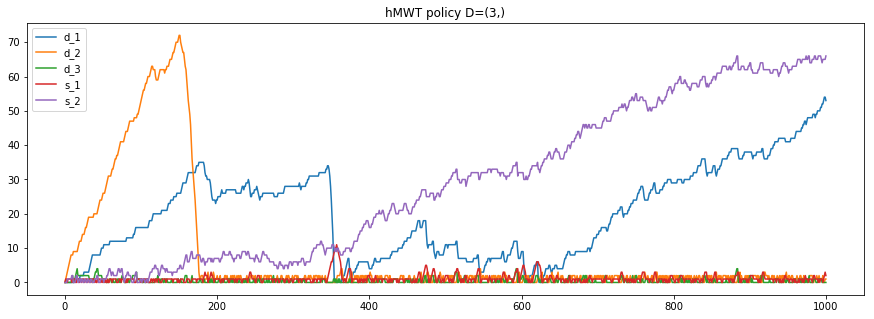

In [16]:
t = test_model.run(1000,P,plot=True)

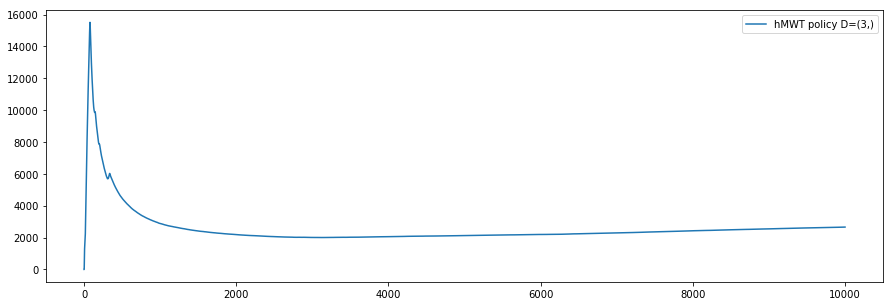

In [52]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

In [25]:
NN = MatchingGraph([(1,1),(1,2),(2,2),(2,3),(3,3)],3,3)
alpha = np.array([3./6., 2./6., 1./6.])
beta = np.array([1.97/6., 2.97/6., 1.06/6.])
arrival_dist = NodesData.items(alpha,beta,NN)
costs = NodesData(np.array([1., 2., 3., 1., 2., 3.]),NN)
P = [hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(NN)
test_model = Model(NN,arrival_dist,costs,x0)

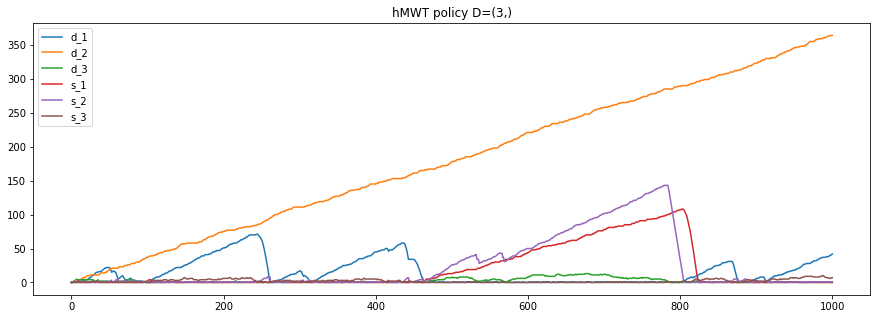

In [26]:
t = test_model.run(1000,P,plot=True)

In [7]:
import time

615.041481256485


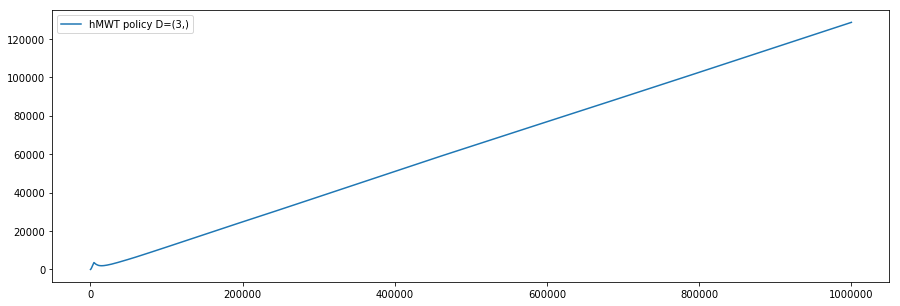

In [27]:
t = time.time()
N = 1000000
c = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

In [4]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
arrival_dist = NodesData.items(alpha,beta,W)
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = [Threshold_policy(np.array([0,0])),MaxWeight_policy(costs),Random_policy(10)]
x0 = State.zeros(W)
test_model = Model(W,arrival_dist,costs,x0)

In [50]:
%lprun -f Matching.feasible Matching(X,pd.Series([0,0,0,0,0],index=['d1','d2','d3','s1','s2']))

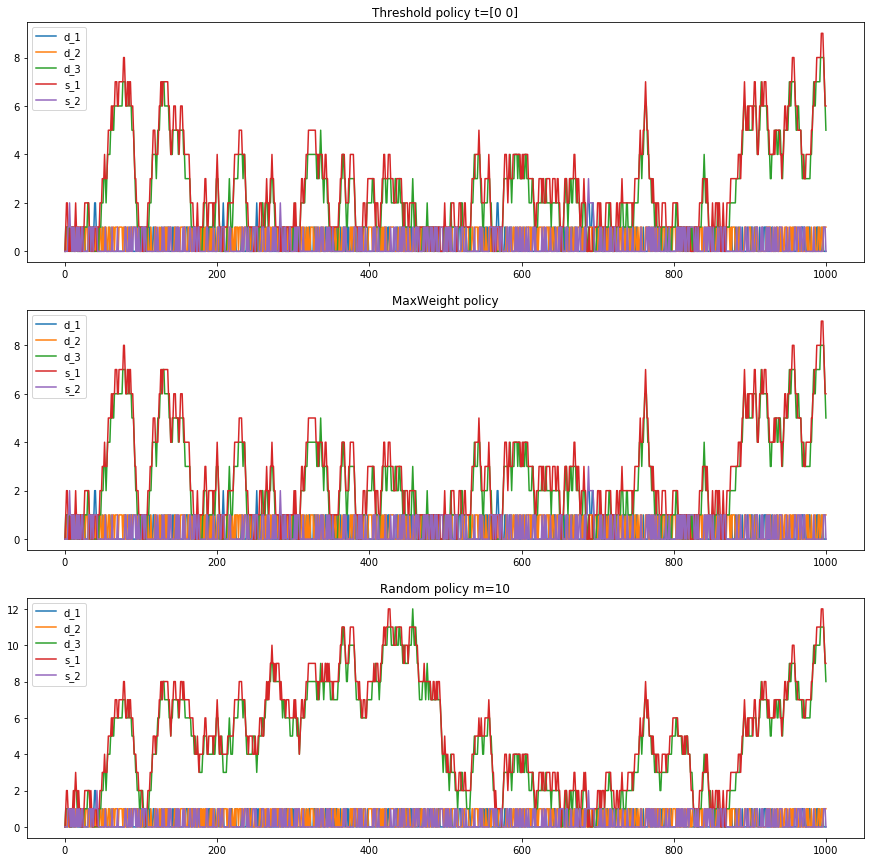

In [5]:
t = test_model.run(1000,P,plot=True)

In [6]:
t

array([[[  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   1.,   1.,   1.],
        [  0.,   1.,   1., ...,   7.,   6.,   5.],
        [  0.,   1.,   2., ...,   7.,   6.,   6.],
        [  0.,   0.,   0., ...,   1.,   1.,   0.]],

       [[  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   1.,   1.,   1.],
        [  0.,   1.,   1., ...,   7.,   6.,   5.],
        [  0.,   1.,   2., ...,   7.,   6.,   6.],
        [  0.,   0.,   0., ...,   1.,   1.,   0.]],

       [[  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   1.,   1.,   1.],
        [  0.,   1.,   1., ...,  10.,   9.,   8.],
        [  0.,   1.,   2., ...,  10.,   9.,   9.],
        [  0.,   0.,   0., ...,   1.,   1.,   0.]]])

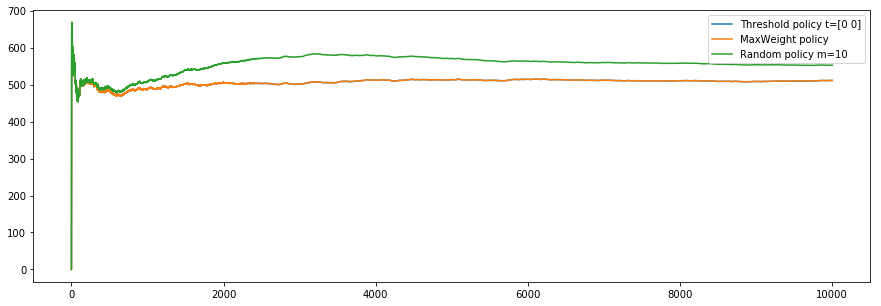

In [7]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

In [4]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
arrival_dist = NodesData.items(alpha,beta,W)
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = [Threshold_policy(np.array([0,0])),MaxWeight_policy(costs),Random_policy(10)]
x0 = State.zeros(W)
test_model = Model(W,arrival_dist,costs,x0)

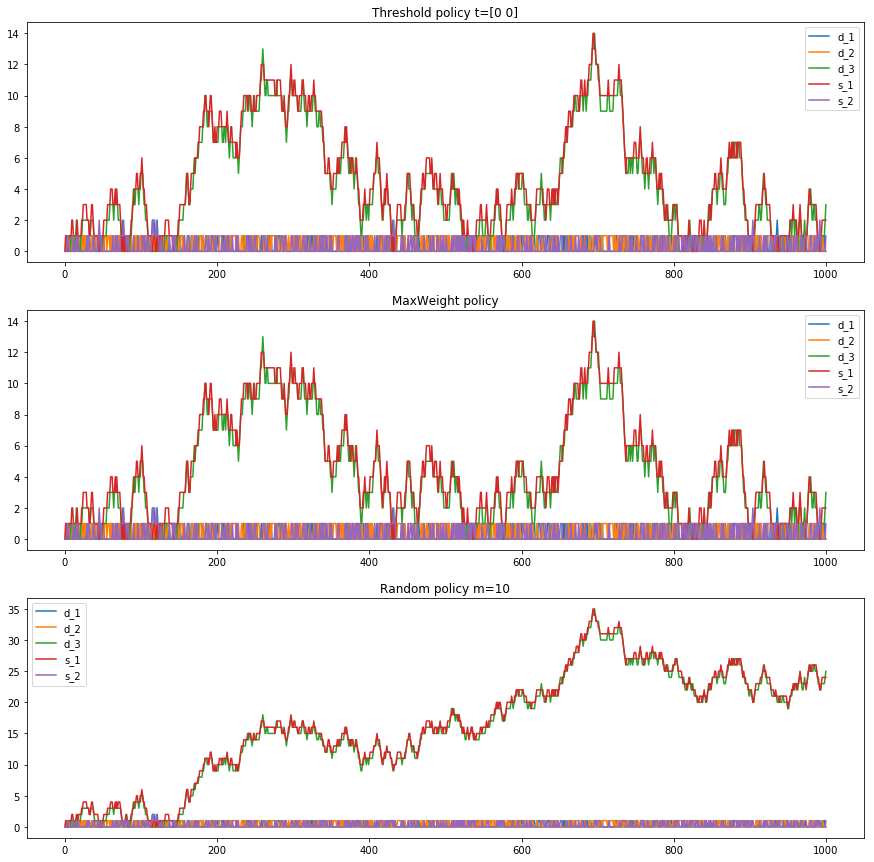

In [5]:
t = test_model.run(1000,P,plot=True)

In [123]:
t

array([[[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,   9.,   9.,   9.],
        [  0.,   0.,   1., ...,  10.,  10.,  10.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,   9.,   9.,   9.],
        [  0.,   0.,   1., ...,  10.,  10.,  10.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,  31.,  31.,  31.],
        [  0.,   0.,   1., ...,  32.,  32.,  32.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]]])

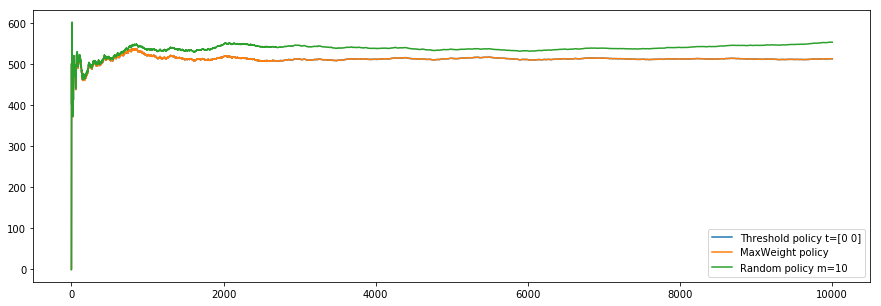

In [124]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

In [15]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
arrival_dist = NodesData.items(alpha,beta,W)
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = [Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5),
     Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5,costs=costs),
     Stolyar_policy(x0,rewards=np.array([1.,1.,1.,1.]),beta=0.5,costs=costs)]
test_model = Model(W,arrival_dist,costs,x0)

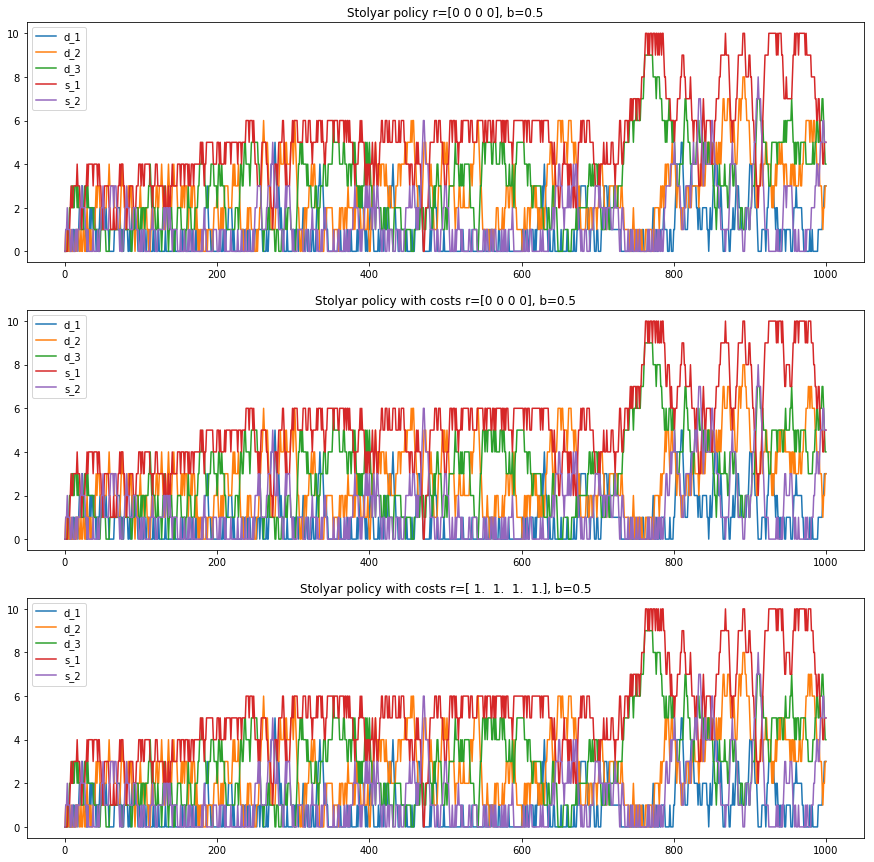

In [16]:
t = test_model.run(1000,P,plot=True)

In [17]:
t

array([[[ 0.,  0.,  1., ...,  3.,  3.,  3.],
        [ 0.,  1.,  0., ...,  2.,  3.,  3.],
        [ 0.,  0.,  0., ...,  5.,  4.,  4.],
        [ 0.,  0.,  0., ...,  5.,  5.,  5.],
        [ 0.,  1.,  1., ...,  5.,  5.,  5.]],

       [[ 0.,  0.,  1., ...,  3.,  3.,  3.],
        [ 0.,  1.,  0., ...,  2.,  3.,  3.],
        [ 0.,  0.,  0., ...,  5.,  4.,  4.],
        [ 0.,  0.,  0., ...,  5.,  5.,  5.],
        [ 0.,  1.,  1., ...,  5.,  5.,  5.]],

       [[ 0.,  0.,  1., ...,  3.,  3.,  3.],
        [ 0.,  1.,  0., ...,  2.,  3.,  3.],
        [ 0.,  0.,  0., ...,  5.,  4.,  4.],
        [ 0.,  0.,  0., ...,  5.,  5.,  5.],
        [ 0.,  1.,  1., ...,  5.,  5.,  5.]]])

In [18]:
(t[1,:,:]==t[2,:,:]).all()

True

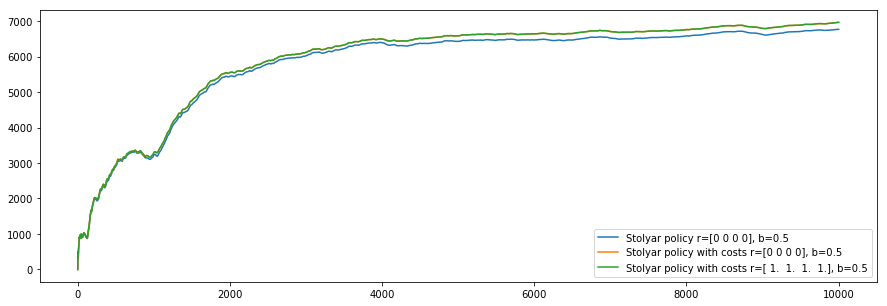

In [19]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

In [60]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = Threshold_policy(np.array([0,0]))
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

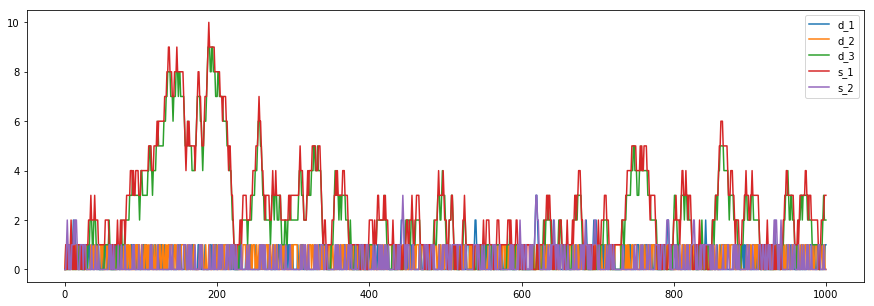

In [61]:
t = test_model.run(1000,P,plot=True)

In [62]:
t

array([[ 0.,  0.,  1., ...,  0.,  1.,  1.],
       [ 0.,  1.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2.,  2.,  2.],
       [ 0.,  1.,  0., ...,  3.,  3.,  3.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

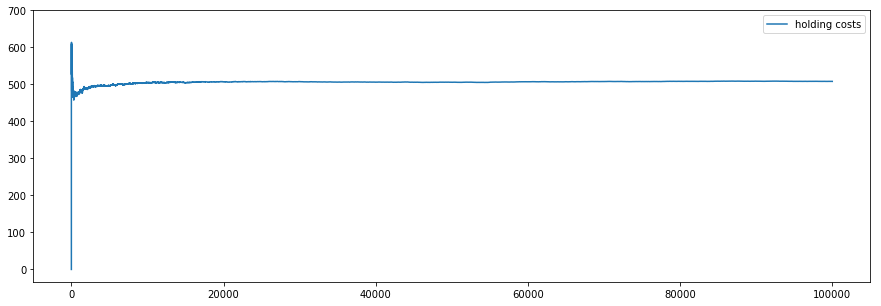

In [63]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [64]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5)
test_model = Model(W,alpha,beta,costs,x0)

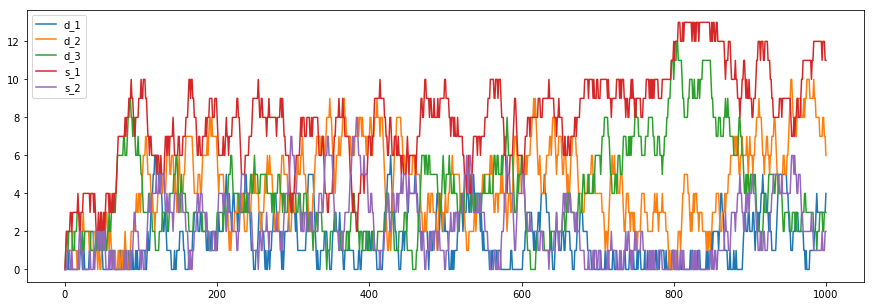

In [65]:
t = test_model.run(1000,P,plot=True)

In [66]:
t

array([[  0.,   0.,   0., ...,   3.,   3.,   4.],
       [  0.,   0.,   0., ...,   7.,   7.,   6.],
       [  0.,   1.,   2., ...,   3.,   3.,   3.],
       [  0.,   1.,   2., ...,  12.,  11.,  11.],
       [  0.,   0.,   0., ...,   1.,   2.,   2.]])

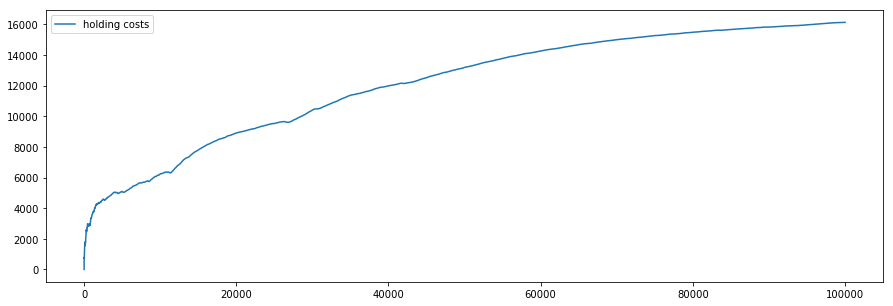

In [67]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [68]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5,costs=costs)
test_model = Model(W,alpha,beta,costs,x0)

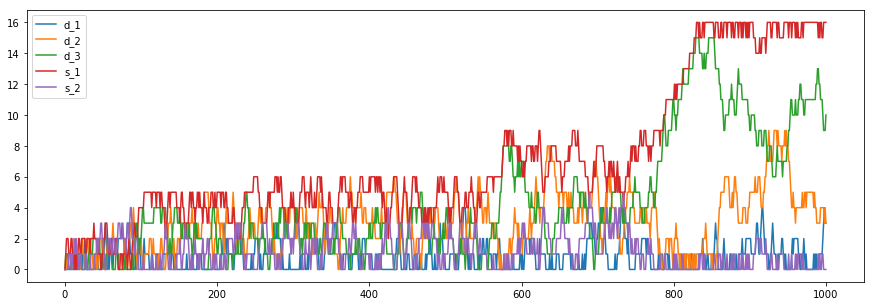

In [69]:
t = test_model.run(1000,P,plot=True)

In [70]:
t

array([[  0.,   0.,   0., ...,   4.,   3.,   3.],
       [  0.,   0.,   1., ...,   3.,   4.,   3.],
       [  0.,   1.,   1., ...,   9.,   9.,  10.],
       [  0.,   1.,   2., ...,  16.,  16.,  16.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

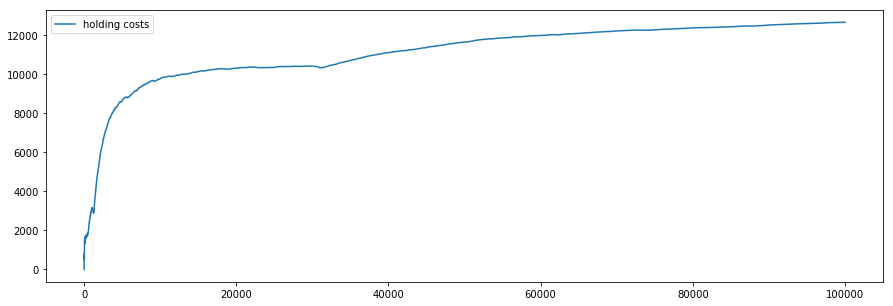

In [71]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [72]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([1.,1.,1.,1.]),beta=0.5,costs=costs)
test_model = Model(W,alpha,beta,costs,x0)

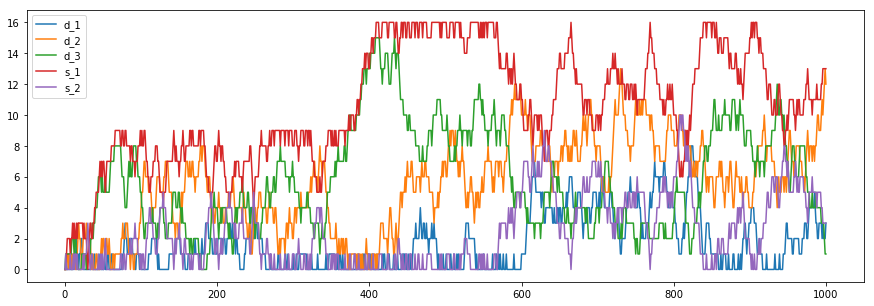

In [73]:
t = test_model.run(1000,P,plot=True)

In [74]:
t

array([[  0.,   0.,   0., ...,   2.,   2.,   3.],
       [  0.,   0.,   0., ...,  12.,  13.,  12.],
       [  0.,   1.,   1., ...,   2.,   1.,   1.],
       [  0.,   0.,   1., ...,  13.,  13.,  13.],
       [  0.,   1.,   0., ...,   3.,   3.,   3.]])

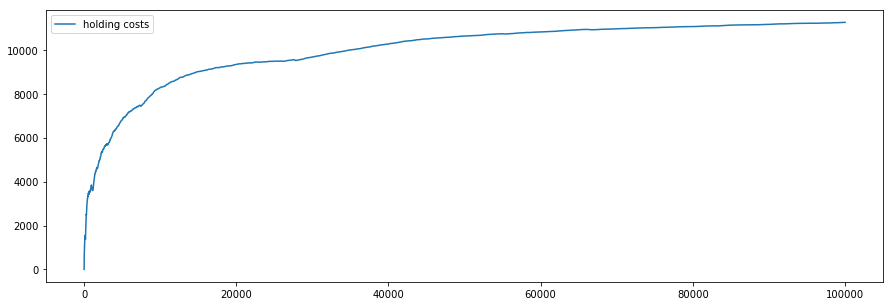

In [75]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [39]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = MaxWeight_policy(costs)
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

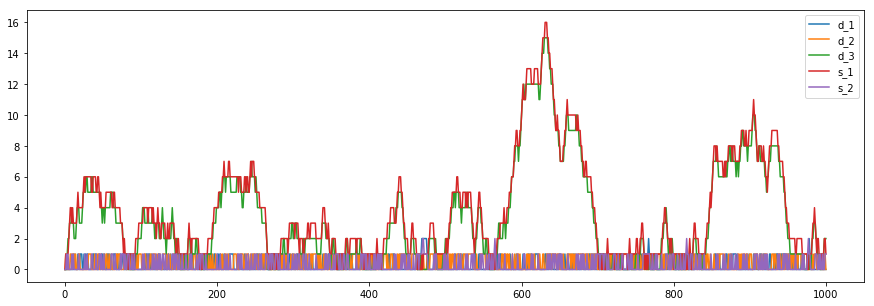

In [40]:
t = test_model.run(1000,P,plot=True)

In [41]:
t

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  2.,  2.,  2.],
       [ 0.,  1.,  0., ...,  2.,  2.,  1.],
       [ 0.,  0.,  1., ...,  0.,  1.,  1.]])

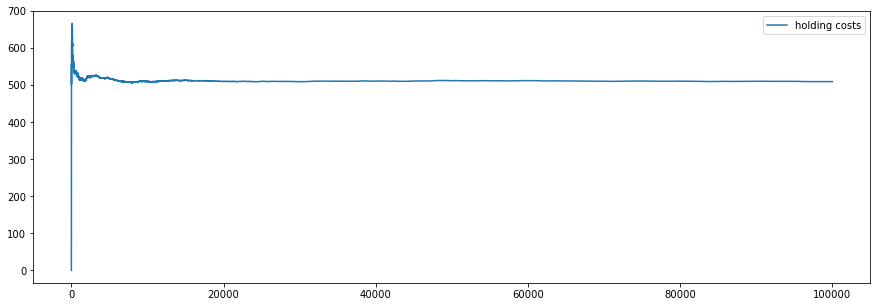

In [42]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [43]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = Random_policy(10)
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

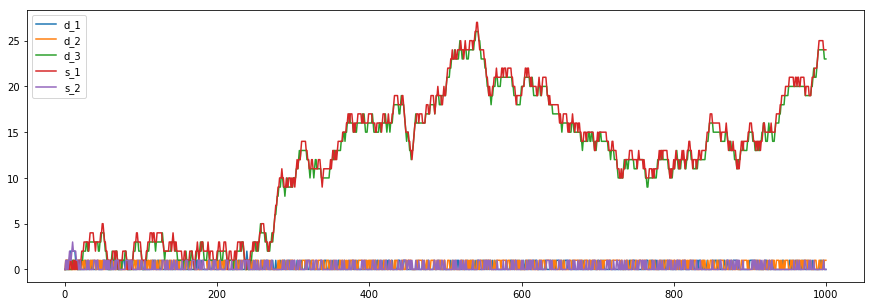

In [44]:
t = test_model.run(1000,P,plot=True)

In [45]:
t

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   1., ...,   1.,   1.,   1.],
       [  0.,   0.,   0., ...,  23.,  23.,  23.],
       [  0.,   0.,   1., ...,  24.,  24.,  24.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.]])

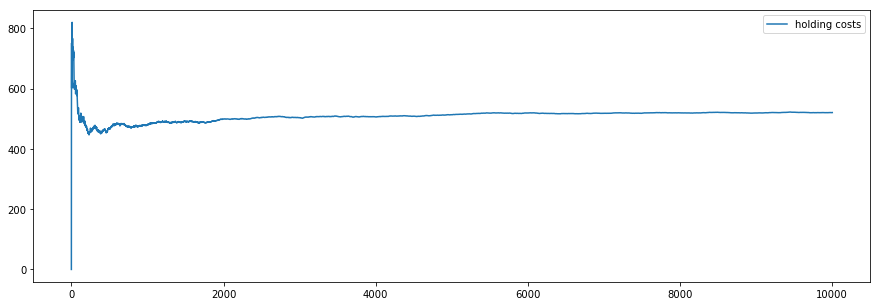

In [46]:
N = 10000
c = test_model.average_cost(N,P,plot=True)